In [211]:
import os
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns

import nfl_data_py as nfl

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [212]:
years = range(2009, 2024)

In [213]:
for year in years:
    if not os.path.exists(f'../.cache/pbp/season={year}'):
        nfl.cache_pbp(years=[year], alt_path='../.cache/pbp', downcast=True)

df_pbp = nfl.import_pbp_data(years, cache=True, alt_path='../.cache/pbp').reset_index(drop=True)

df_schedules = nfl.import_schedules(years).reset_index(drop=True)

df_stadiums_locs = pd.read_csv('../data/stadiums.csv')[['stadium_id','lat','lon','timezone']]

df_elevations = pd.read_csv('../data/stadium_elevation.csv')

cols = ['season','player_id','player_name','years_exp','draft_number','age']
df_rosters = nfl.import_seasonal_rosters(years)[cols]

2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


KeyboardInterrupt: 

In [ ]:
# Columns to keep
variables = [
    'season', 'game_id', 'play_id', 'week', 'home_team', 'away_team', 'kicker_player_name', 'kicker_player_id', 
    'field_goal_attempt', 'field_goal_result', 'kick_distance', 'game_seconds_remaining',
    'game_half', 'season_type', 'posteam_type', 'roof', 'surface', 'wind', 'temp', 'stadium_id',
    'score_differential', 'timeout_prev_play', 'timeout_team_prev_play', 'posteam'
] # score_differential = posteam_score - defteam_score

# Sort by game_id and play_id and create columns for previous play's timeout and description
df_pbp = df_pbp.sort_values(['game_id', 'play_id'])
df_pbp['timeout_prev_play'] = df_pbp['timeout'].shift(1)
df_pbp['timeout_team_prev_play'] = df_pbp['timeout_team'].shift(1)
df_pbp['desc_prev_play'] = df_pbp['desc'].shift(1)

# Filter for field goal attempts
df_fg = df_pbp[df_pbp['field_goal_attempt'] == True][variables].reset_index(drop=True)

# Fix missing timeout team data for specific plays
fixes = {
    ('2013_07_SD_JAX', 2389.0): 'JAX',
    ('2015_09_JAX_NYJ', 2731.0): 'JAX'
}
for (game_id, play_id), team in fixes.items():
    df_fg.loc[(df_fg.play_id == play_id) & (df_fg.game_id == game_id), 'timeout_team_prev_play'] = team

# Determine if kicker was iced
df_fg['iced'] = np.where(
    (df_fg['timeout_prev_play'] == True) & (df_fg['posteam'] != df_fg['timeout_team_prev_play']), 
    1, 
    0
)

# Create binary columns for various conditions
df_fg['overtime'] = (df_fg['game_half'] == 'Overtime').astype(int)
df_fg['postseason'] = (df_fg['season_type'] == 'POST').astype(int)
df_fg['home_stadium'] = (df_fg['posteam_type'] == 'home').astype(int)
df_fg['grass_surface'] = df_fg['surface'].isin(['grass', 'grass ', 'dessograss']).astype(int)
df_fg['outdoors'] = (df_fg['roof'].isin(['outdoors', 'open'])).astype(int)

# Handle missing temperature and wind data
df_fg['temp'] = df_fg['temp'].fillna(70)
df_fg['wind'] = df_fg['wind'].fillna(0)

# Fill missing surface data based on the most common surface for each stadium
stadiums_with_surface = df_fg.query('surface == ""').stadium_id.unique()
for stadium_id in stadiums_with_surface:
    v_counts = df_fg.query('stadium_id == @stadium_id').surface.value_counts()
    surface = v_counts.index[0] 
    if (surface == "") & (len(v_counts) > 1):
        surface = v_counts.index[1]
    df_fg.loc[(df_fg.stadium_id == stadium_id) & (df_fg.surface == ""), 'surface'] = surface

# Special case for a specific stadium
df_fg.loc[df_fg.stadium_id == "GER00", 'surface'] = "dessograss"

# Merge stadium elevations
df_fg = df_fg.merge(df_elevations, how='left', on='stadium_id')

# Create a binary column for field goal made
df_fg['field_goal_made'] = df_fg['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

df_fg = df_fg.merge(df_schedules[['game_id', 'gameday', 'gametime']], on='game_id', how='left')

df_fg = df_fg.merge(df_stadiums_locs, how='left', on='stadium_id')

# Find the stadium elevation for the kicker's home stadium
home_stadiums = (df_schedules[['season', 'home_team', 'stadium_id']]
    .groupby(['season', 'home_team'])
    .agg(total=('stadium_id', 'count'), 
         home_stadium=('stadium_id', lambda x: x.value_counts().index[0]))
    .reset_index()
    .sort_values('total', ascending=True)
    [['season', 'home_team', 'home_stadium']]
    .merge(df_elevations, how='left', left_on='home_stadium', right_on='stadium_id')
    .drop(['stadium_id','home_stadium'], axis=1)
    .rename({'elevation':'home_stadium_elevation', 'home_team':'team'}, axis=1)
)
team_mapper = {
    'OAK': 'LV',
    'SD': 'LAC',
    'STL': 'LA'
}
home_stadiums['team'] = home_stadiums['team'].replace(team_mapper)
df_fg = df_fg.merge(home_stadiums, how='left', left_on=['season', 'posteam'], right_on=['season', 'team'])

df_fg['elevation_diff'] = df_fg['elevation'] - df_fg['home_stadium_elevation']

# Convert start time to datetime and convert to local time
def convert_timezone(row):
    return row['start_time'].tz_convert(pytz.timezone(row['timezone']))
df_fg['start_time'] = pd.to_datetime(df_fg.gameday + ' ' + df_fg.gametime, format='%Y-%m-%d %H:%M')
df_fg['start_time'] = df_fg['start_time'].dt.tz_localize(pytz.timezone('US/Eastern'))
df_fg['start_time'] = df_fg.apply(convert_timezone, axis=1)

# Join the roster data
df_fg = df_fg.merge(df_rosters, how='left', left_on=['season', 'kicker_player_id'], right_on=['season', 'player_id'])

pressure_situations = df_fg.overtime | \
    ((df_fg.score_differential <= 0) & (df_fg.score_differential >= -3) & (df_fg.game_seconds_remaining <= 500)) | \
    ((df_fg.postseason == 1) & (df_fg.score_differential <= 0) & (df_fg.score_differential >= -3)) | \
    (df_fg.iced == 1)

df_fg['pressure_situation'] = pressure_situations.astype(int)

# Drop unnecessary columns
drop_cols = [
    'kicker_player_name','game_half', 'season_type', 'posteam_type', 'surface', 'roof',
    'timeout_prev_play', 'timeout_team_prev_play', 'field_goal_result', 
    'field_goal_attempt', 'stadium_id', 'gameday', 'gametime', 'lat', 'lon', 'timezone', 'home_stadium_elevation',
    'start_time', 'player_id', 'team', 'posteam'
]

# Reorder columns
df_fg = df_fg[df_fg.columns.drop('player_name').insert(df_fg.columns.get_loc('kicker_player_id') - 1, 'player_name')]
df_fg = df_fg[df_fg.columns.drop('field_goal_made').insert(len(df_fg.columns)-1, 'field_goal_made')]
df_fg = df_fg[df_fg.columns.drop('years_exp').insert(df_fg.columns.get_loc('kicker_player_id') + 1, 'years_exp')]
df_fg = df_fg[df_fg.columns.drop('draft_number').insert(df_fg.columns.get_loc('kicker_player_id') + 2, 'draft_number')]
df_fg = df_fg[df_fg.columns.drop('age').insert(df_fg.columns.get_loc('kicker_player_id') + 3, 'age')]
df_fg = df_fg.drop(drop_cols, axis=1)

In [ ]:
df_weather = pd.read_pickle('../data/weather.pkl')

In [ ]:
light_rain = [
    'Light Rain Fog/Mist', 'Light Freezing Rain', 'Light Rain', 'Light Rain And Windy', 
    'Thunderstorm Light Rain', 'Thunderstorm In Vicinity Light Rain Fog/Mist', 'Light Sleet', 
    'Drizzle And Humid', 'Light Rain And Breezy', 'Lt Rain', 'Lt Rain, Fog', 'Possible Light Rain', 
    'Possible Drizzle', 'Rain Fog/Mist', 'Mod Rain, Fog', 'Light Drizzle', 'Chance Showers', 'Thunder, Lt Rain',
    'Slight Chance Thunderstorms', 'Lt Rain', 'Drizzle'
]

rain = [
    'Rain Showers', 'Rain', 'Rain Fog/Mist And Breezy', 'Definite Rain', 'Rain And Windy', 
    'Rain And Humid', 'Heavy Rain Fog/Mist', 'Showers', 'Likely Rain', 'Thunderstorm Rain Fog/Mist',
    'Heavy Rain', 'Thunderstorms'
]

light_snow = [
    'Light Snow (< 1 In.)', 'Light Snow And Windy', 'Light Snow', 'Possible Light Snow', 
    'Light Snow Fog/Mist'
]

medium_snow = [
    'Snow And Breezy', 'Snow', 'Flurries', 'Possible Flurries', 'Wintry Mix'
]

heavy_snow = [
    'Heavy Snow', 'Blizzard', 'Heavy Snow Freezing Fog', 'Blowing Snow And Breezy'
]

In [ ]:
# cap all of the visibility values at 10 max
df_weather['kickoff_visibility'] = np.where(df_weather['kickoff_visibility'] > 10, 10, df_weather['kickoff_visibility'])
df_weather['q2_visibility'] = np.where(df_weather['q2_visibility'] > 10, 10, df_weather['q2_visibility'])
df_weather['q3_visibility'] = np.where(df_weather['q3_visibility'] > 10, 10, df_weather['q3_visibility'])
df_weather['q4_visibility'] = np.where(df_weather['q4_visibility'] > 10, 10, df_weather['q4_visibility'])

In [ ]:
# ordinal encode the weather, 0 if no rain, 1 if light rain, 2 if rain
df_weather['kickoff_rain'] = np.where(df_weather['kickoff_weather'].isin(light_rain), 1, 0)
df_weather['kickoff_rain'] = np.where(df_weather['kickoff_weather'].isin(rain), 2, df_weather['kickoff_rain'])
df_weather['kickoff_rain'] = np.where(df_weather['kickoff_weather'].isna(), None, df_weather['kickoff_rain'])

df_weather['q2_rain'] = np.where(df_weather['q2_weather'].isin(light_rain), 1, 0)
df_weather['q2_rain'] = np.where(df_weather['q2_weather'].isin(rain), 2, df_weather['q2_rain'])
df_weather['q2_rain'] = np.where(df_weather['q2_weather'].isna(), None, df_weather['q2_rain'])

df_weather['q3_rain'] = np.where(df_weather['q3_weather'].isin(light_rain), 1, 0)
df_weather['q3_rain'] = np.where(df_weather['q3_weather'].isin(rain), 2, df_weather['q3_rain'])
df_weather['q3_rain'] = np.where(df_weather['q3_weather'].isna(), None, df_weather['q3_rain'])

df_weather['q4_rain'] = np.where(df_weather['q4_weather'].isin(light_rain), 1, 0)
df_weather['q4_rain'] = np.where(df_weather['q4_weather'].isin(rain), 2, df_weather['q4_rain'])
df_weather['q4_rain'] = np.where(df_weather['q4_weather'].isna(), None, df_weather['q4_rain'])


In [ ]:
# ordinal encode the snow weather by quarter, 0 if no snow, 1 if light snow, 2 if medium snow, 3 if heavy snow
df_weather['kickoff_snow'] = np.where(df_weather['kickoff_weather'].isin(light_snow), 1, 0)
df_weather['kickoff_snow'] = np.where(df_weather['kickoff_weather'].isin(medium_snow), 2, df_weather['kickoff_snow'])
df_weather['kickoff_snow'] = np.where(df_weather['kickoff_weather'].isin(heavy_snow), 3, df_weather['kickoff_snow'])
df_weather['kickoff_snow'] = np.where(df_weather['kickoff_weather'].isna(), None, df_weather['kickoff_snow'])

df_weather['q2_snow'] = np.where(df_weather['q2_weather'].isin(light_snow), 1, 0)
df_weather['q2_snow'] = np.where(df_weather['q2_weather'].isin(medium_snow), 2, df_weather['q2_snow'])
df_weather['q2_snow'] = np.where(df_weather['q2_weather'].isin(heavy_snow), 3, df_weather['q2_snow'])
df_weather['q2_snow'] = np.where(df_weather['q2_weather'].isna(), None, df_weather['q2_snow'])

df_weather['q3_snow'] = np.where(df_weather['q3_weather'].isin(light_snow), 1, 0)
df_weather['q3_snow'] = np.where(df_weather['q3_weather'].isin(medium_snow), 2, df_weather['q3_snow'])
df_weather['q3_snow'] = np.where(df_weather['q3_weather'].isin(heavy_snow), 3, df_weather['q3_snow'])
df_weather['q3_snow'] = np.where(df_weather['q3_weather'].isna(), None, df_weather['q3_snow'])

df_weather['q4_snow'] = np.where(df_weather['q4_weather'].isin(light_snow), 1, 0)
df_weather['q4_snow'] = np.where(df_weather['q4_weather'].isin(medium_snow), 2, df_weather['q4_snow'])
df_weather['q4_snow'] = np.where(df_weather['q4_weather'].isin(heavy_snow), 3, df_weather['q4_snow'])
df_weather['q4_snow'] = np.where(df_weather['q4_weather'].isna(), None, df_weather['q4_snow'])

In [ ]:
df_weather[df_weather['kickoff_weather'].isin(rain)].shape[0] * 5.3

307.4

In [ ]:
# cols to merge: visibility, snow, rain
df_fg_kickoff = df_fg.copy()
df_fg_q2 = df_fg[(df_fg.game_seconds_remaining <= 3*15*60) & (df_fg.game_seconds_remaining > 2*15*60) & (df_fg.overtime == 0)]
df_fg_q3 = df_fg[(df_fg.game_seconds_remaining <= 2*15*60) & (df_fg.game_seconds_remaining > 15*60) & (df_fg.overtime == 0)]
df_fg_q4_on = df_fg[(df_fg.game_seconds_remaining <= 15*60) | (df_fg.overtime == 1)]

df_fg_kickoff = df_fg_kickoff.merge(df_weather[['game_id', 'kickoff_visibility', 'kickoff_snow', 'kickoff_rain']], on='game_id', how='left')
df_fg_q2 = df_fg_q2.merge(df_weather[['game_id', 'q2_visibility', 'q2_snow', 'q2_rain']], on='game_id', how='left')
df_fg_q3 = df_fg_q3.merge(df_weather[['game_id', 'q3_visibility', 'q3_snow', 'q3_rain']], on='game_id', how='left')
df_fg_q4_on = df_fg_q4_on.merge(df_weather[['game_id', 'q4_visibility', 'q4_snow', 'q4_rain']], on='game_id', how='left')

df_fg.loc[df_fg_q2.index, 'visibility'] = df_fg_q2['q2_visibility']
df_fg.loc[df_fg_q3.index, 'visibility'] = df_fg_q3['q3_visibility']
df_fg.loc[df_fg_q4_on.index, 'visibility'] = df_fg_q4_on['q4_visibility']
df_fg['visibility'] = np.where(df_fg['visibility'].isna(), df_fg_kickoff['kickoff_visibility'], df_fg.visibility)
df_fg['visibility'] = np.where(df_fg['outdoors'] == 0, 10.0, df_fg.visibility)

df_fg.loc[df_fg_q2.index, 'snow'] = df_fg_q2['q2_snow']
df_fg.loc[df_fg_q3.index, 'snow'] = df_fg_q3['q3_snow']
df_fg.loc[df_fg_q4_on.index, 'snow'] = df_fg_q4_on['q4_snow']
df_fg['snow'] = np.where(df_fg['snow'].isna(), df_fg_kickoff['kickoff_snow'], df_fg.snow)
df_fg['snow'] = np.where(df_fg['outdoors'] == 0, 0, df_fg.snow)

df_fg.loc[df_fg_q2.index, 'rain'] = df_fg_q2['q2_rain']
df_fg.loc[df_fg_q3.index, 'rain'] = df_fg_q3['q3_rain']
df_fg.loc[df_fg_q4_on.index, 'rain'] = df_fg_q4_on['q4_rain']
df_fg['rain'] = np.where(df_fg['rain'].isna(), df_fg_kickoff['kickoff_rain'], df_fg.rain)
df_fg['rain'] = np.where(df_fg['outdoors'] == 0, 0, df_fg.rain)

In [ ]:
df_weather.replace({np.NaN: None}, inplace=True)

In [ ]:
# Replace missing years_exp with the season - rookie year
rookie_year_mapper = {
    '00-0026003': 2008,
    '00-0021940': 2003
}
df_fg['years_exp'] = df_fg['years_exp'].fillna(df_fg['season'] - df_fg['kicker_player_id'].map(rookie_year_mapper))

# Replace missing draft_number with 350
df_fg['draft_number'] = df_fg['draft_number'].fillna(350).astype(int)

### b. Impute missing "visibility" data with average value for it's weather condition group

In [ ]:
clear_conditions = [
    'Fair', 'Sunny', 'Mostly Sunny', 'Clear', 'Mostly Clear', 'Na','°F'
]

cloudy_conditions = [
    'Mostly Cloudy', 'Partly Cloudy', 'Overcast', 'A Few Clouds', 'Few Clouds', 
    'Partly Sunny', 'Cloudy', 'Humid And Mostly Cloudy', 'Mostly Cloudy And Breezy',
    'Overcast With Haze', 'Overcast And Windy', 'Overcast And Breezy',
    'Partly Cloudy And Breezy', 'Partly Cloudy With Haze', 'Fair With Haze',
    'Humid And Overcast', 'Windy And Partly Cloudy', 'Windy And Overcast',
    'Dry And Partly Cloudy', 'Windy And Mostly Cloudy', 'Humid And Overcast',
    'A Few Clouds And Breezy', 'Decreasing Clouds', 'A Few Clouds With Haze',
    'Breezy And Mostly Cloudy', 'A Few Clouds And Breezy'
]

rainy_conditions = [
    'Light Rain', 'Rain', 'Rain Showers', 'Heavy Rain', 'Lt Rain', 'Lt Rain, Fog',
    'Light Drizzle', 'Thunderstorm Light Rain', 'Thunderstorm Rain Fog/Mist',
    'Heavy Rain Fog/Mist', 'Thunderstorm In Vicinity Light Rain Fog/Mist', 'Rain Fog/Mist',
    'Showers', 'Showers In Vicinity', 'Chance Showers', 'Mod Rain, Fog', 'Possible Drizzle',
    'Possible Light Rain', 'Light Rain And Breezy', 'Light Rain And Windy', 'Rain Fog/Mist And Breezy',
    'Light Freezing Rain', 'Humid And Partly Cloudy', 'Windy And Partly Cloudy', 'Fair And Breezy',
    'Possible Light Rain', 'Rain And Humid', 'Likely Rain', 'Chance Rain Showers',
    'Definite Rain', 'Slight Chance Thunderstorms', 'Heavy Rain Fog/Mist', 'Breezy And Humid',
    'Humid And Overcast', 'Rain And Windy', 'Blowing Snow And Breezy', 'Rain Showers',
    'Showers In Vicinity', 'Rain And Humid', 'Light Drizzle', 'Light Rain', 'Light Rain Fog/Mist',
    'Areas Drizzle', 'Drizzle', 'Drizzle And Humid', 'Thunderstorms'
]

snowy_conditions = [
    'Snow', 'Blizzard', 'Light Snow', 'Heavy Snow', 'Light Snow Fog/Mist', 'Snow And Breezy',
    'Heavy Snow Freezing Fog', 'Flurries', 'Possible Flurries', 'Light Sleet', 'Light Snow And Windy',
    'Snow And Breezy', 'Blowing Snow And Breezy', 'Light Snow (< 1 In.)', 'Possible Light Snow',
    'Wintry Mix', 'Sleet'
]

foggy_conditions = [
    'Fog/Mist', 'Overcast With Haze', 'Patchy Fog', 'Fog', 'Foggy', 'Humid', 'Humid And Mostly Cloudy',
    'Humid And Overcast', 'Areas Fog', 'Dry', 'Humid And Partly Cloudy', 'Windy And Partly Cloudy',
    'Fair With Haze', 'Fog', 'Dangerously Windy And Overcast', 'Shallow Fog' 
]

windy_conditions = [
    'Overcast And Windy', 'Overcast And Breezy', 'Windy And Partly Cloudy', 'Windy And Overcast',
    'Breezy', 'Breezy And Humid', 'Windy And Mostly Cloudy', 'Windy And Overcast', 'Windy And Partly Cloudy',
    'Windy And Overcast', 'Possible Light Rain And Windy', 'Humid And Overcast', 'Blowing Snow And Breezy',
    'Clear Windy'
]

mixed_conditions = [
    'Light Rain Fog/Mist', 'Rain Fog/Mist', 'Overcast With Haze', 'Thunderstorm Light Rain',
    'Thunderstorm Rain Fog/Mist', 'Light Drizzle', 'Fog/Mist', 'Light Snow Fog/Mist',
    'Thunderstorm In Vicinity Light Rain Fog/Mist', 'Rain Fog/Mist And Breezy', 'Rain And Humid',
    'Humid And Overcast', 'Rain Showers', 'Showers In Vicinity', 'Chance Thunderstorms', 'Thunder, Lt Rain',
    'Rain And Windy', 'Rain And Humid', 'Possible Drizzle', 'Possible Light Rain', 'Light Sleet',
    'Windy And Partly Cloudy', 'Windy And Overcast', 'Fair And Breezy', 'Humid And Mostly Cloudy'
]

# stack kickoff_weather, q2_weather, q3_weather, q4_weather together, then take the average visibility by each group of weather conditions
df_weather_conditions = df_weather[['game_id', 'kickoff_weather', 'q2_weather', 'q3_weather', 'q4_weather', 'kickoff_visibility', 'q2_visibility', 'q3_visibility', 'q4_visibility']]
df_weather_conditions = df_weather_conditions.melt(id_vars=['game_id', 'kickoff_visibility', 'q2_visibility', 'q3_visibility', 'q4_visibility'], value_vars=['kickoff_weather', 'q2_weather', 'q3_weather', 'q4_weather'], var_name='quarter', value_name='weather')
df_weather_conditions['weather'] = df_weather_conditions['weather'].str.strip()

df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(clear_conditions), 'clear', None)
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(cloudy_conditions), 'cloudy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(rainy_conditions), 'rainy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(snowy_conditions), 'snowy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(foggy_conditions), 'foggy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(windy_conditions), 'windy', df_weather_conditions['weather_group'])
df_weather_conditions['weather_group'] = np.where(df_weather_conditions['weather'].isin(mixed_conditions), 'mixed', df_weather_conditions['weather_group'])

df_weather_conditions = df_weather_conditions.groupby(['weather_group']).agg(visibility=('kickoff_visibility', 'mean')).reset_index()

In [ ]:
df_weather_conditions

,weather_group,visibility
0,clear,9.2951
1,cloudy,8.96366
2,foggy,4.600897
3,mixed,8.089202
4,rainy,6.876016
5,snowy,4.573333
6,windy,8.842105


In [ ]:
# set weather group for kickoff
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(clear_conditions), 'clear', None)
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(cloudy_conditions), 'cloudy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(rainy_conditions), 'rainy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(snowy_conditions), 'snowy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(foggy_conditions), 'foggy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(windy_conditions), 'windy', df_weather['kickoff_weather_group'])
df_weather['kickoff_weather_group'] = np.where(df_weather['kickoff_weather'].isin(mixed_conditions), 'mixed', df_weather['kickoff_weather_group'])

# set weather group for q2
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(clear_conditions), 'clear', None)
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(cloudy_conditions), 'cloudy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(rainy_conditions), 'rainy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(snowy_conditions), 'snowy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(foggy_conditions), 'foggy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(windy_conditions), 'windy', df_weather['q2_weather_group'])
df_weather['q2_weather_group'] = np.where(df_weather['q2_weather'].isin(mixed_conditions), 'mixed', df_weather['q2_weather_group'])

# set weather group for q3
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(clear_conditions), 'clear', None)
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(cloudy_conditions), 'cloudy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(rainy_conditions), 'rainy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(snowy_conditions), 'snowy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(foggy_conditions), 'foggy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(windy_conditions), 'windy', df_weather['q3_weather_group'])
df_weather['q3_weather_group'] = np.where(df_weather['q3_weather'].isin(mixed_conditions), 'mixed', df_weather['q3_weather_group'])

# set weather group for q4
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(clear_conditions), 'clear', None)
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(cloudy_conditions), 'cloudy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(rainy_conditions), 'rainy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(snowy_conditions), 'snowy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(foggy_conditions), 'foggy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(windy_conditions), 'windy', df_weather['q4_weather_group'])
df_weather['q4_weather_group'] = np.where(df_weather['q4_weather'].isin(mixed_conditions), 'mixed', df_weather['q4_weather_group'])

# Copy and filter the field goal DataFrame for different quarters
df_fg_kickoff = df_fg.copy()
df_fg_q2 = df_fg[(df_fg.game_seconds_remaining <= 3*15*60) & (df_fg.game_seconds_remaining > 2*15*60) & (df_fg.overtime == 0)]
df_fg_q3 = df_fg[(df_fg.game_seconds_remaining <= 2*15*60) & (df_fg.game_seconds_remaining > 15*60) & (df_fg.overtime == 0)]
df_fg_q4_on = df_fg[(df_fg.game_seconds_remaining <= 15*60) | (df_fg.overtime == 1)]

# Merge weather data for each quarter
df_fg_kickoff = df_fg_kickoff.merge(df_weather[['game_id', 'kickoff_weather_group']], on='game_id', how='left')
df_fg_q2 = df_fg_q2.merge(df_weather[['game_id', 'q2_weather_group']], on='game_id', how='left')
df_fg_q3 = df_fg_q3.merge(df_weather[['game_id', 'q3_weather_group']], on='game_id', how='left')
df_fg_q4_on = df_fg_q4_on.merge(df_weather[['game_id', 'q4_weather_group']], on='game_id', how='left')

# Update the weather_group column in the original DataFrame
df_fg.loc[df_fg_q2.index, 'weather_group'] = df_fg_q2['q2_weather_group']
df_fg.loc[df_fg_q3.index, 'weather_group'] = df_fg_q3['q3_weather_group']
df_fg.loc[df_fg_q4_on.index, 'weather_group'] = df_fg_q4_on['q4_weather_group']
df_fg['weather_group'] = np.where(df_fg['weather_group'].isna(), df_fg_kickoff['kickoff_weather_group'], df_fg.weather_group)
df_fg['weather_group'] = np.where(df_fg['outdoors'] == 0, 'indoors', df_fg.weather_group)

In [ ]:
# impute missing visibility data
df_fg.loc[df_fg.visibility.isna(), "visibility"] = df_fg.loc[df_fg.visibility.isna()].merge(df_weather_conditions, how='left', on='weather_group', suffixes=('','_new')).set_index(df_fg.loc[df_fg.visibility.isna()].index).visibility_new

In [ ]:
df_fg.drop(['weather_group'], axis=1, inplace=True)

### c. Add Field Goal Over Expectation features for kicker

In [ ]:
#count the number of field goals attempted and made by distance
years_2000 = range(2000, 2024)
df_fg_2000 = (nfl.import_pbp_data(years_2000, cache=True, alt_path='../.cache/pbp')
              [['season','game_id','play_id','kicker_player_id','kick_distance','field_goal_result','field_goal_attempt']]
              .query('field_goal_attempt == True'))
df_fg_2000['field_goal_made'] = df_fg_2000['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)
df_fg_2000 = df_fg_2000.drop(['field_goal_result','field_goal_attempt'], axis=1)

df_binom = df_fg_2000.groupby('kick_distance').agg({'game_id':'count','field_goal_made':'sum'}).reset_index()
df_binom = (df_binom.sort_values(by='kick_distance', ascending=True)
              .rename({'game_id':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))

df_binom['fg_pct'] = df_binom['field_goal_makes'] / df_binom['field_goal_attempts']

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


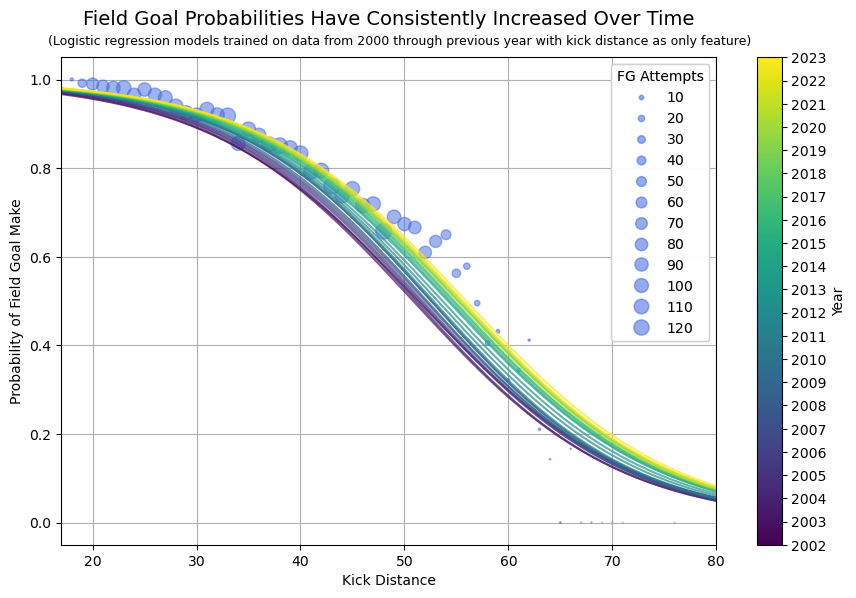

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

# Ensure the dataset contains the required columns
assert 'kick_distance' in df_fg_2000.columns
assert 'field_goal_made' in df_fg_2000.columns
assert 'season' in df_fg_2000.columns

# Initialize lists to store models and years
models = defaultdict()
years = range(2009, 2024)

# Generate polynomial degree 4 logistic regression models for each year
for year in years_2000:
    if year < 2002:
        continue
    X = df_fg_2000[df_fg_2000['season'] < year][['kick_distance']].values
    y = df_fg_2000[df_fg_2000['season'] < year]['field_goal_made'].values
    model_poly_4 = LogisticRegression(max_iter=1000)
    model_poly_4.fit(X, y)
    models[year] = model_poly_4

# Generate values for plotting
x_values = np.linspace(0, 80, 1000).reshape(-1, 1)

# Extract the kick distances (as integers) and corresponding success percentages for scatter plot
x = df_binom['kick_distance'].values
y = df_binom['fg_pct'].values
marker_sizes = df_binom['field_goal_attempts'].values * 0.15

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6.5))

# Plot the scatter plot
scatter = ax.scatter(x, y, color='royalblue', s=marker_sizes, label='Observed FG Make Frequency', alpha=0.5)

# Colors for each year's model
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# Plot polynomial logistic regression predictions for each year
for i, year in enumerate(range(2002, 2024)):
    y_values = models[year].predict_proba(x_values)[:, 1]
    ax.plot(x_values, y_values, color=colors[i], alpha=0.7, label=f'{year}')

# Set labels, title, and legend
ax.set_xlabel('Kick Distance')
ax.set_ylabel('Probability of Field Goal Make')
ax.set_title('Field Goal Probabilities Have Consistently Increased Over Time', y=1.05, fontsize=14)
# add subtitle
plt.suptitle('(Logistic regression models trained on data from 2000 through previous year with kick distance as only feature)', y=.875, x=.45, fontsize=9)

# Create a scalar mappable for color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=2002, vmax=2023))
sm.set_array([])  # Dummy array for the color bar

# Add color bar
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(2002, 2024, 1))
cbar.set_label('Year')

# Add a legend for the scatter plot
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5, color='royalblue')
scatter_legend = plt.legend(handles, labels, loc="upper right", title="FG Attempts")

# Ensure the gridlines align with the primary x-axis
ax.add_artist(scatter_legend)

# Send gridlines to the back
ax.set_axisbelow(True)

# Limit x axis to 17 to 80
ax.set_xlim([17, 80])

# Add gridlines
ax.grid()

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make room for subtitle
plt.show()

In [ ]:
# Code without smoothing

# df_fg.sort_values(['game_id', 'play_id'], inplace=True, ignore_index=True)

# # Calculate the field goal percentage over expectation for each kicker for their last n kicks
# df_fg['fg_pct_over_expectation'] = df_fg['field_goal_made'] - df_fg['fg_proba']

# # Function to calculate rolling mean excluding the current row
# def rolling_mean_exclude_current(x, n):
#     return x.rolling(window = n, min_periods=n).mean().shift(1)

# df_fg['FGPOE_L10'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 10))
# df_fg['FGPOE_L20'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 20))
# df_fg['FGPOE_L30'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 30))
# df_fg['FGPOE_L35'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 35))
# df_fg['FGPOE_L40'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 40))
# df_fg['FGPOE_L50'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 50))
# df_fg['FGPOE_L75'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 75))
# df_fg['FGPOE_L100'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, 100))


# def expanding_mean_exclude_current(x):
#     return x.expanding(min_periods=25).mean().shift(1)

# # Calculate career average of all kicks prior to each kick
# df_fg['career_fg_pct_over_expectation'] = df_fg.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(expanding_mean_exclude_current)

In [ ]:
# drop 2000 and 2001
df_fg_2000 = df_fg_2000[df_fg_2000['season'] > 2001]

# Predict fg_proba for each kick using the model from the previous year
for yr in range(2002, 2024):
    df_fg_2000.loc[df_fg_2000['season'] == yr, 'fg_proba'] = models[yr].predict_proba(df_fg_2000.loc[df_fg_2000['season'] == yr, 'kick_distance'].values.reshape(-1, 1))[:, 1]

# Add Field Goal Over Expectation features for kicker
df_fg_2000.sort_values(['game_id', 'play_id'], inplace=True, ignore_index=True)

# Calculate the field goal percentage over expectation for each kicker for their last n kicks
df_fg_2000['fg_pct_over_expectation'] = df_fg_2000['field_goal_made'] - df_fg_2000['fg_proba']

# Function to calculate rolling mean excluding the current row
def rolling_mean_exclude_current(x, n, league_avg):
    fgpoe_lX = x.rolling(window=n, min_periods=n).mean().shift(1)
    personal_avg_n = x.expanding(min_periods=1).mean().shift(1)[:n]
    personal_avg_n.iloc[0] = 1
    count_n = x.expanding(min_periods=1).count().shift(1)[:n]
    count_n.iloc[0] = 0
    fgpoe_lX.iloc[:n] = (count_n * personal_avg_n + (n - count_n) * league_avg) / n
    return fgpoe_lX

# Calculate league average fg_pct_over_expectation
league_avg_fgpoe = df_fg_2000['fg_pct_over_expectation'].mean()

# Calculate rolling means for different window sizes with league average adjustment
window_sizes = [10, 20, 30, 35, 40, 50, 75, 100]
for window_size in window_sizes:
    column_name = f'FGPOE_L{window_size}'
    df_fg_2000[column_name] = df_fg_2000.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: rolling_mean_exclude_current(x, window_size, league_avg_fgpoe))

# Function to calculate expanding mean excluding the current row
def expanding_mean_exclude_current(x, min_periods, league_avg):

    fgpoe_lX = x.rolling(window=n, min_periods=n).mean().shift(1)
    personal_avg_n = x.expanding(min_periods=1).mean().shift(1)[:n]
    personal_avg_n.iloc[0] = 1
    count_n = x.expanding(min_periods=1).count().shift(1)[:n]
    count_n.iloc[0] = 0
    fgpoe_lX.iloc[:n] = (count_n * personal_avg_n + (n - count_n) * league_avg) / n
    return fgpoe_lX

def expanding_mean_exclude_current(x, min_periods, league_avg):
    exp_mean = x.expanding(min_periods=min_periods).mean().shift(1)

    count_n = x.expanding(min_periods=1).count().shift(1)[:min_periods]
    count_n.iloc[0] = 0
    exp_mean_n = x.expanding(min_periods=1).mean().shift(1)[:min_periods]
    exp_mean_n.iloc[0] = 1
    exp_mean.iloc[:min_periods] = (count_n * exp_mean_n + (min_periods - count_n) * league_avg) / min_periods

    return exp_mean

# Calculate career average of all kicks prior to each kick, smoothing with league average up to 100 kicks
df_fg_2000['career_fg_pct_over_expectation'] = df_fg_2000.groupby('kicker_player_id')['fg_pct_over_expectation'].transform(lambda x: expanding_mean_exclude_current(x, 100, league_avg_fgpoe))

In [ ]:
cols = ['game_id', 'play_id', 'fg_proba', 'fg_pct_over_expectation', 'FGPOE_L10', 'FGPOE_L20', 'FGPOE_L30', 
        'FGPOE_L35', 'FGPOE_L40', 'FGPOE_L50', 'FGPOE_L75', 'FGPOE_L100', 'career_fg_pct_over_expectation']

if 'fg_proba' not in df_fg.columns:
    df_fg = df_fg.merge(df_fg_2000[cols], on=['game_id', 'play_id'], how='left')

print('L20:', round(df_fg.FGPOE_L20.isna().sum() / df_fg.shape[0]*100,2))
print('L30:', round(df_fg.FGPOE_L30.isna().sum() / df_fg.shape[0]*100,2))
print('L35:', round(df_fg.FGPOE_L35.isna().sum() / df_fg.shape[0]*100,2))
print('L40:', round(df_fg.FGPOE_L40.isna().sum() / df_fg.shape[0]*100,2))
print('L50:', round(df_fg.FGPOE_L50.isna().sum() / df_fg.shape[0]*100,2))
print('L75:', round(df_fg.FGPOE_L75.isna().sum() / df_fg.shape[0]*100,2))
print('L100:', round(df_fg.FGPOE_L100.isna().sum() / df_fg.shape[0]*100,2))

L20: 0.0
L30: 0.0
L35: 0.0
L40: 0.0
L50: 0.0
L75: 0.0
L100: 0.0


In [ ]:
n = 50
avgs = (df_fg.groupby('kicker_player_id').agg({'player_name':'first','game_id':'count','fg_pct_over_expectation':'mean'})
                                         .reset_index()
                                         .sort_values('fg_pct_over_expectation', ascending=False)
                                         .rename({'game_id':'fg_attempts'}, axis=1)
                                         .query('fg_attempts >= @n'))
avgs.head(20)

,kicker_player_id,player_name,fg_attempts,fg_pct_over_expectation
56,00-0029597,Justin Tucker,460,0.116171
119,00-0037224,Cameron Dicker,59,0.115917
118,00-0036854,Evan McPherson,112,0.092165
20,00-0020962,Rob Bironas,150,0.089260
18,00-0020578,Matt Bryant,308,0.085661
14,00-0019646,Sebastian Janikowski,282,0.083853
85,00-0033303,Harrison Butker,257,0.081787
86,00-0033702,Younghoe Koo,174,0.077345
32,00-0023853,Matt Prater,459,0.076504
76,00-0032087,Josh Lambo,151,0.076411


In [ ]:
df_fg.player_name.value_counts()

player_name
Justin Tucker           460
Matt Prater             459
Mason Crosby            452
Robbie Gould            412
Nick Folk               409
Greg Zuerlein           407
Ryan Succop             403
Graham Gano             403
Stephen Gostkowski      400
Adam Vinatieri          330
Brandon McManus         321
Matt Bryant             308
Dan Bailey              299
Randy Bullock           283
Sebastian Janikowski    282
Chris Boswell           282
Phil Dawson             277
Jason Myers             276
Cairo Santos            264
Dustin Hopkins          262
Harrison Butker         257
Dan Carpenter           256
Mike Nugent             248
Wil Lutz                244
Jake Elliott            211
Shaun Suisham           210
Steven Hauschka         209
Ka'imi Fairbairn        208
Billy Cundiff           206
David Akers             205
Nick Novak              201
Josh Brown              201
Daniel Carlson          196
Connor Barth            193
Blair Walsh             192
Jason Sa

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_27330/2913474437.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_labels = df_player_seasons.groupby('season').apply(lambda x: x['attempt_number'].median()).to_dict()


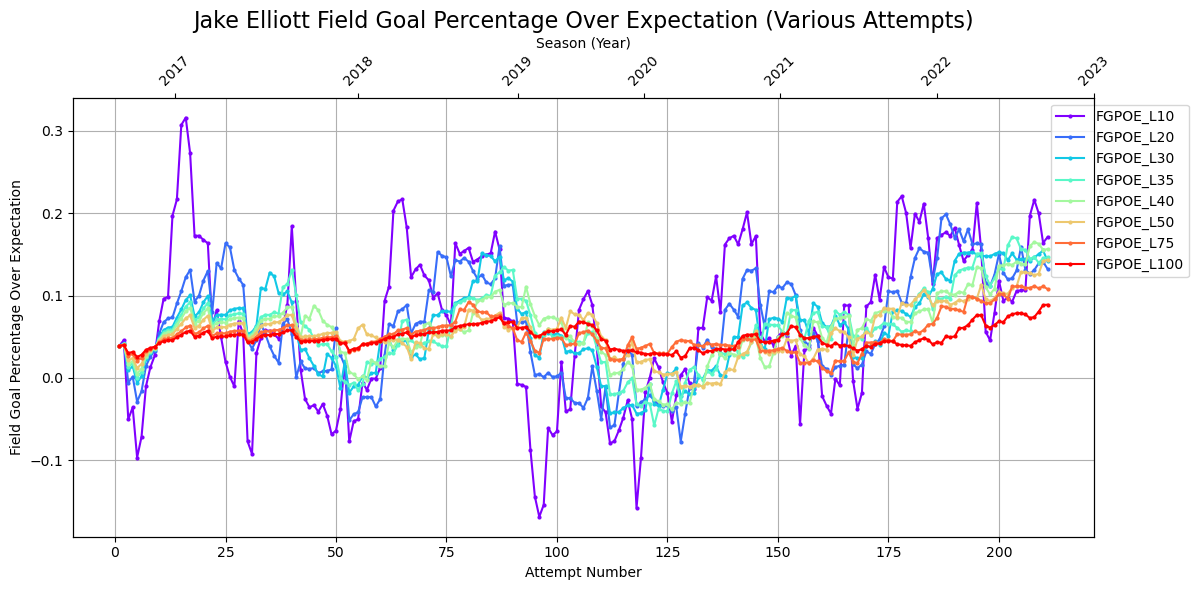

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Filter the DataFrame for player
player = 'Jake Elliott'
features = ['FGPOE_L10', 'FGPOE_L20', 'FGPOE_L30', 'FGPOE_L35', 'FGPOE_L40', 'FGPOE_L50', 'FGPOE_L75', 'FGPOE_L100']
df_player = df_fg.query('player_name == @player')

# Calculate attempt_number before dropping NaNs
df_player['attempt_number'] = df_player.groupby('player_name').cumcount() + 1

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Colors for each feature
colors = plt.cm.rainbow(np.linspace(0, 1, len(features)))

# Plot each feature over the number of attempts
for feature, color in zip(features, colors):
    df_player_feature = df_player.dropna(subset=[feature])
    ax1.plot(df_player_feature['attempt_number'], df_player_feature[feature], marker='.', markersize=4, label=feature, color=color)

# Set the title and labels for the primary x-axis (attempt number)
ax1.set_title(f'{player} Field Goal Percentage Over Expectation (Various Attempts)', fontsize=16)
ax1.set_xlabel('Attempt Number')
ax1.set_ylabel('Field Goal Percentage Over Expectation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Create a secondary x-axis to show the season (year)
ax2 = ax1.twiny()
ax2.set_xlabel('Season (Year)')

# Set the tick positions and labels for the secondary x-axis
df_player_seasons = df_player.dropna(subset=['season'])
season_labels = df_player_seasons.groupby('season').apply(lambda x: x['attempt_number'].median()).to_dict()
season_positions = list(season_labels.values())
season_years = list(season_labels.keys())

ax2.set_xticks(season_positions)
ax2.set_xticklabels(season_years, rotation=45)

# Ensure the gridlines align with the primary x-axis
ax2.grid(False)

# Add legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

# Adjust layout to make room for secondary x-axis labels
plt.tight_layout()
ax1.grid()
plt.show()


In [ ]:
features = [
    'years_exp', 'draft_number', 'age',
    'kick_distance', 'game_seconds_remaining', 'wind', 'temp',
    'score_differential', 'iced', 'overtime', 'postseason', 'home_stadium',
    'grass_surface', 'outdoors', 'elevation',
    'elevation_diff', 'pressure_situation', 'visibility',
    'snow', 'rain', 'FGPOE_L10',
    'FGPOE_L20', 'FGPOE_L30', 'FGPOE_L35', 'FGPOE_L40', 'FGPOE_L50',
    'FGPOE_L75', 'FGPOE_L100', 'career_fg_pct_over_expectation'
]

X = df_fg[features]
y = df_fg[['field_goal_made']]

In [ ]:
df_fg.columns

Index(['season', 'game_id', 'play_id', 'week', 'home_team', 'away_team',
       'player_name', 'kicker_player_id', 'years_exp', 'draft_number', 'age',
       'kick_distance', 'game_seconds_remaining', 'wind', 'temp',
       'score_differential', 'iced', 'overtime', 'postseason', 'home_stadium',
       'grass_surface', 'outdoors', 'elevation', 'elevation_diff',
       'pressure_situation', 'field_goal_made', 'visibility', 'snow', 'rain',
       'fg_proba', 'fg_pct_over_expectation', 'FGPOE_L10', 'FGPOE_L20',
       'FGPOE_L30', 'FGPOE_L35', 'FGPOE_L40', 'FGPOE_L50', 'FGPOE_L75',
       'FGPOE_L100', 'career_fg_pct_over_expectation'],
      dtype='object')

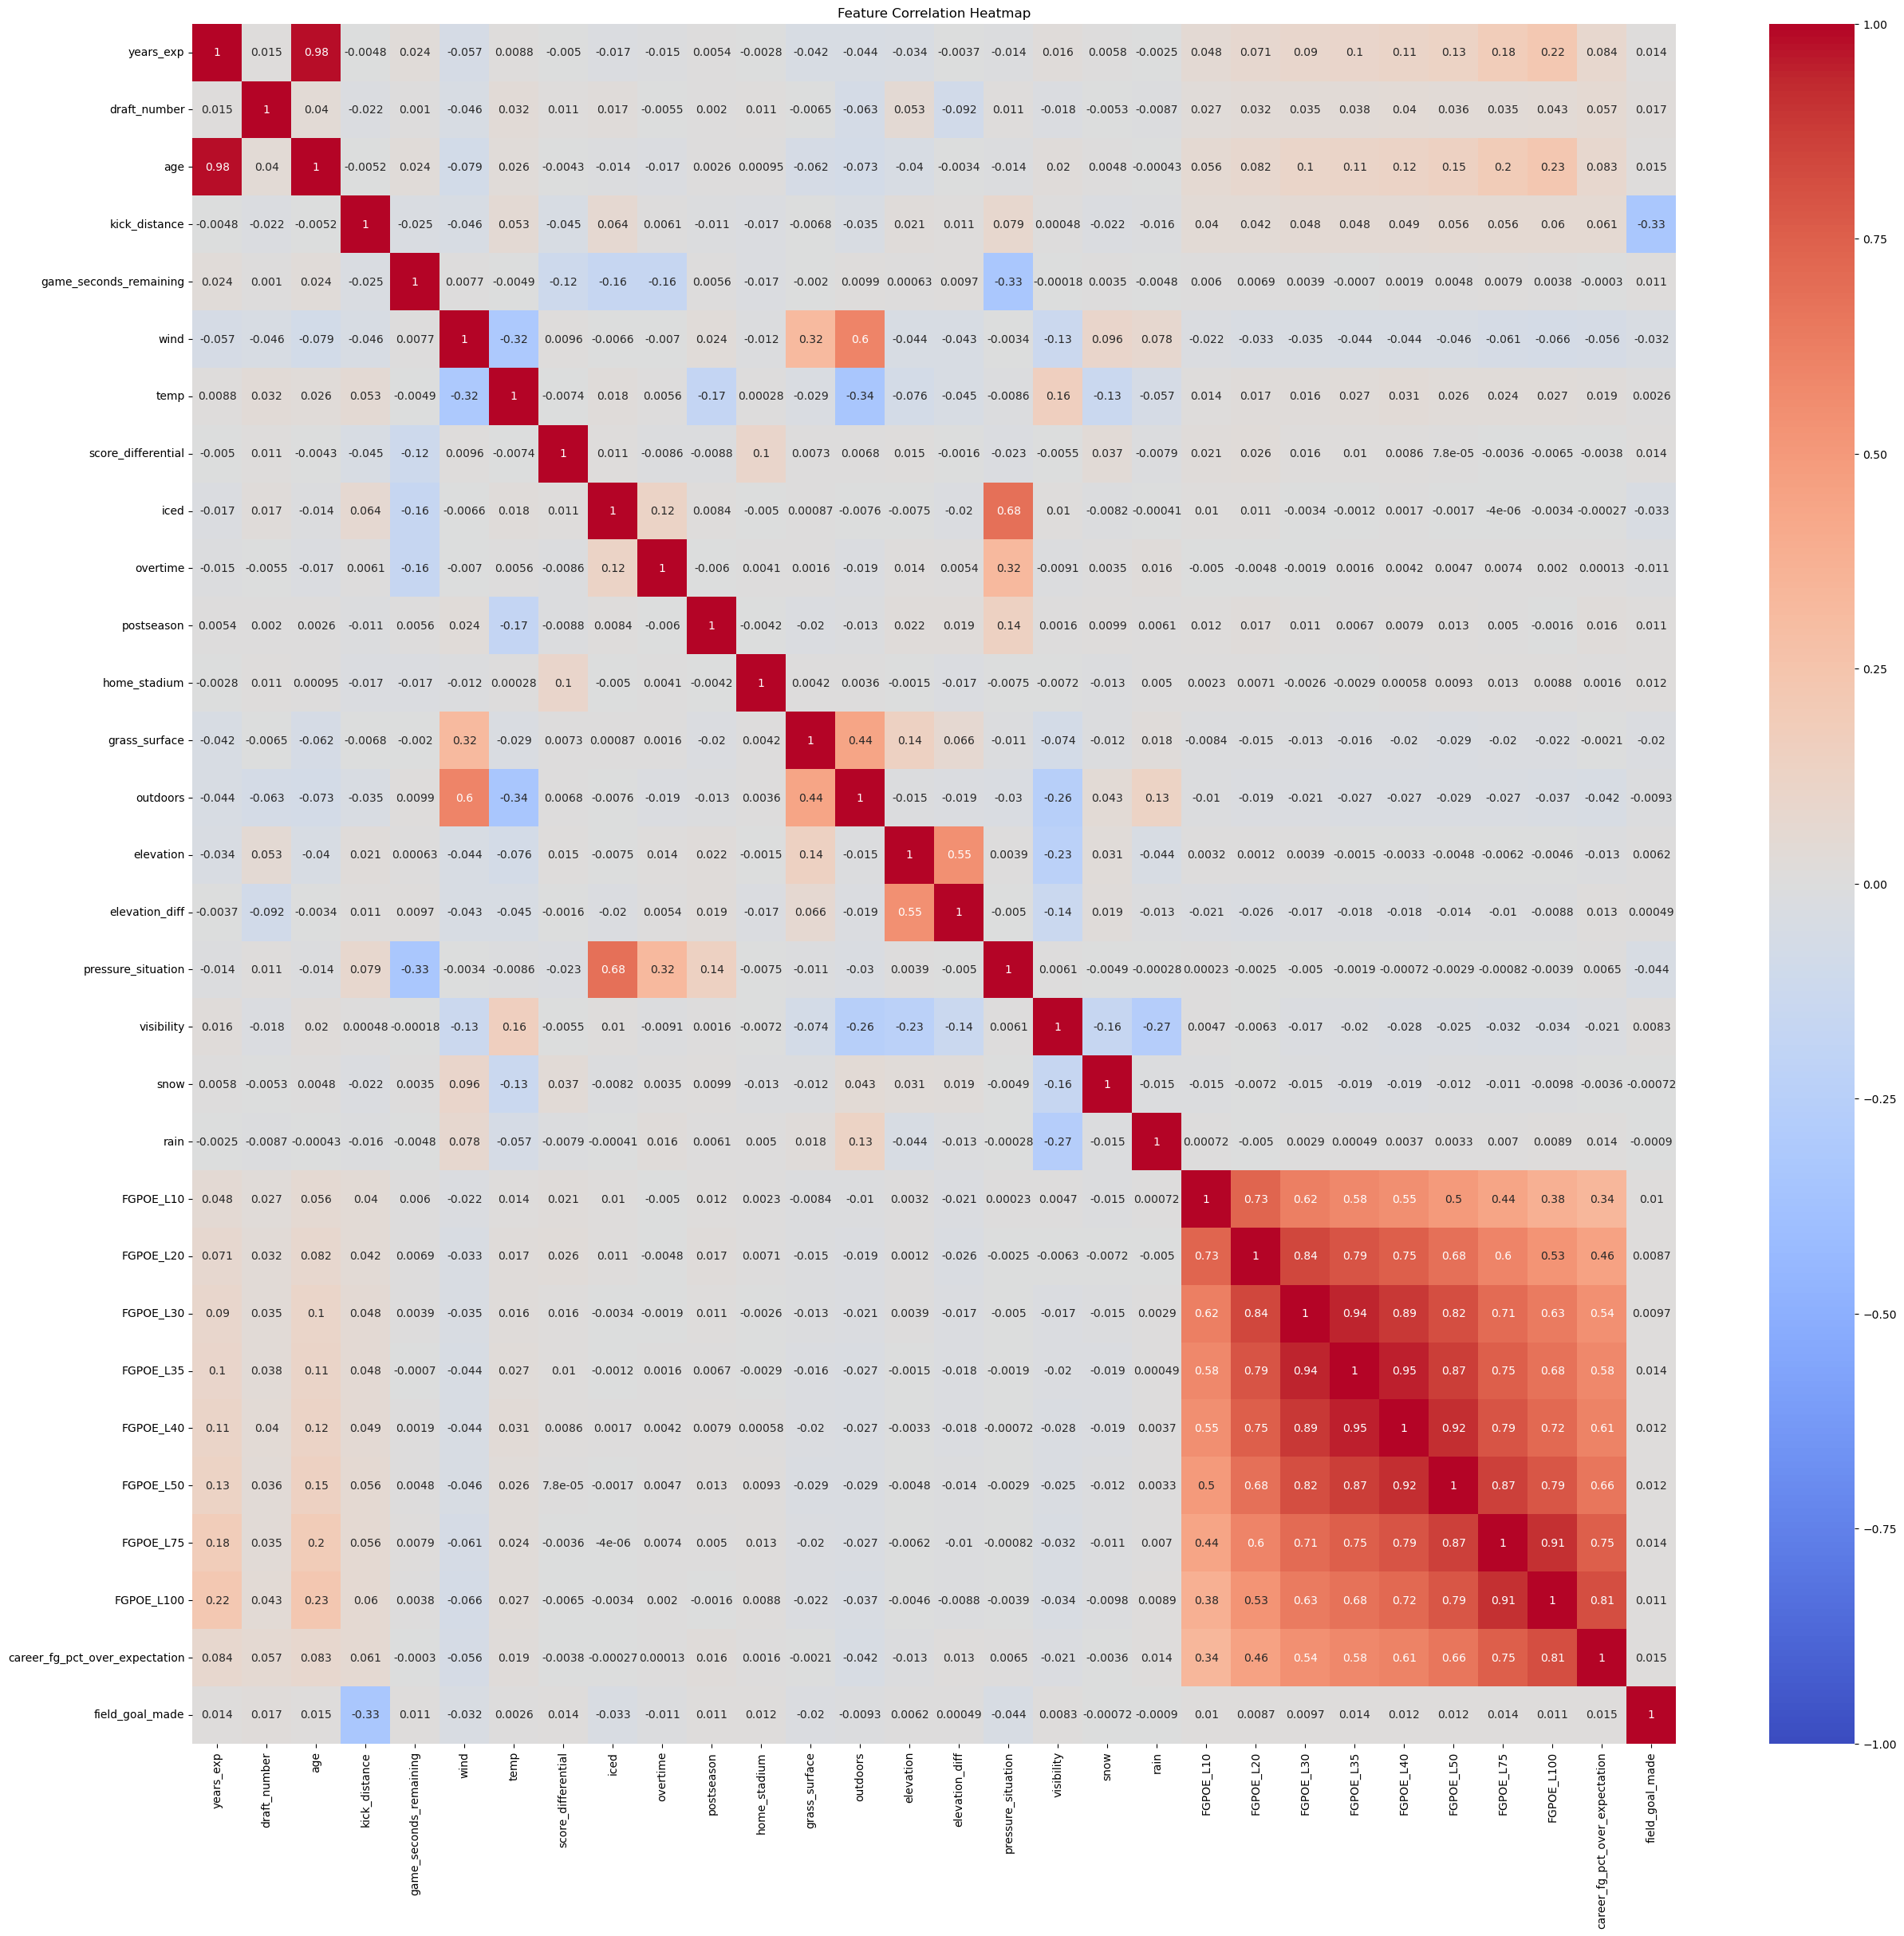

In [ ]:
cols = [
    'years_exp', 'draft_number', 'age',
    'kick_distance', 'game_seconds_remaining', 'wind', 'temp',
    'score_differential', 'iced', 'overtime', 'postseason', 'home_stadium',
    'grass_surface', 'outdoors', 'elevation',
    'elevation_diff', 'pressure_situation', 'visibility',
    'snow', 'rain', 'FGPOE_L10',
    'FGPOE_L20', 'FGPOE_L30', 'FGPOE_L35', 'FGPOE_L40', 'FGPOE_L50',
    'FGPOE_L75', 'FGPOE_L100', 'career_fg_pct_over_expectation', 'field_goal_made'
]

correlation_matrix = df_fg[cols].corr()
# Round the correlation matrix to 2 decimal places
correlation_matrix = correlation_matrix.round(6)

# Plot the heatmap
plt.figure(figsize=(30, 28))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
['kick_distance', 'draft_number', 'age', 'wind', 'temp',
'iced', 'overtime', 'postseason', 'home_stadium',
'grass_surface', 'elevation', 'elevation_diff',
'pressure_situation', 'visibility', 'snow', 'rain',
'FGPOE_L35', 'career_fg_pct_over_expectation']

Index(['season', 'game_id', 'play_id', 'week', 'home_team', 'away_team',
       'player_name', 'kicker_player_id', 'years_exp', 'draft_number', 'age',
       'kick_distance', 'game_seconds_remaining', 'wind', 'temp',
       'score_differential', 'iced', 'overtime', 'postseason', 'home_stadium',
       'grass_surface', 'outdoors', 'elevation', 'elevation_diff',
       'pressure_situation', 'field_goal_made', 'visibility', 'snow', 'rain',
       'fg_proba', 'fg_pct_over_expectation', 'FGPOE_L10', 'FGPOE_L20',
       'FGPOE_L30', 'FGPOE_L35', 'FGPOE_L40', 'FGPOE_L50', 'FGPOE_L75',
       'FGPOE_L100', 'career_fg_pct_over_expectation'],
      dtype='object')

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_27330/97987357.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='viridis')


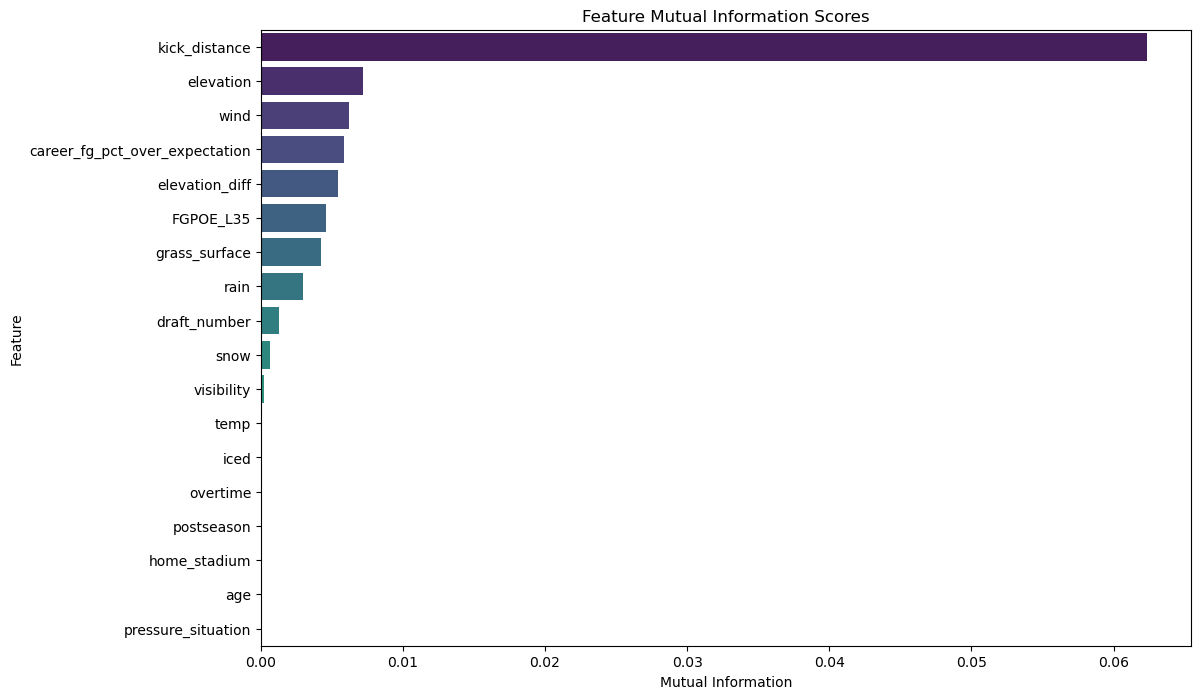

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame
# df_fg = pd.DataFrame(...)  # Load your actual DataFrame here
# X = df_fg[cols]  # Features
# y = df_fg['field_goal_made']  # Target variable

# Calculate mutual information
mi = mutual_info_classif(X, y.values.ravel())

# Create a DataFrame for visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})

# Sort by mutual information
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot mutual information
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='viridis')
plt.title('Feature Mutual Information Scores')
plt.show()

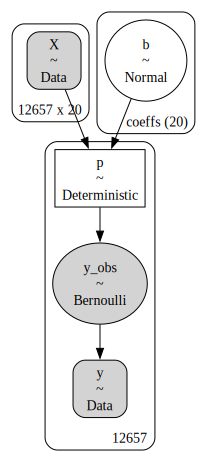

In [324]:
import pymc as pm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

features = ['season','kick_distance', 'draft_number', 'age', 'wind', 'temp',
            'iced', 'overtime', 'postseason', 'home_stadium',
            'grass_surface', 'elevation', 'elevation_diff',
            'pressure_situation', 'visibility', 'snow', 'rain',
            'FGPOE_L35', 'career_fg_pct_over_expectation']
X_all = df_fg[features]
y_all = df_fg['field_goal_made']

X_all = X_all.apply(pd.to_numeric, errors='coerce')

X_all_standardized = ((X_all - X_all.mean()) / X_all.std()).to_numpy()

X_all_standardized = np.hstack([np.ones((X_all_standardized.shape[0], 1)), X_all_standardized])

X_train, X_test, y_train, y_test = train_test_split(X_all_standardized, y_all, test_size=0.2, random_state=123)

labels = ['Intercept'] + features

with pm.Model(coords={"coeffs": labels}) as logistic_model:
    # data containers
    X = pm.Data('X', X_train)
    y = pm.Data('y', y_train)

    # priors
    b = pm.Normal('b', mu=0, sigma=10, dims='coeffs')
    
    # logistic regression
    logits = pm.math.dot(X, b)
    p = pm.Deterministic('p', pm.math.sigmoid(logits))
    
    # likelihood
    pm.Bernoulli('y_obs', p=p, observed=y)

pm.model_to_graphviz(logistic_model)

#    # Sample from the posterior
#     trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# # Predict probabilities on the test set
# with logistic_model:
#     p_test = pm.sample_posterior_predictive(trace, var_names=['p'])
#     p_test_mean = p_test['posterior_predictive']['p'].mean(axis=0)

# # Calculate log loss on the test set
# test_log_loss = log_loss(y_test, p_test_mean)
# print(f'Log Loss on the test set: {test_log_loss}')

# # Predict probabilities on the entire dataset
# with logistic_model:
#     logits_all = pm.math.dot(X_all_standardized, trace['posterior']['beta'].mean(axis=0))
#     p_all = pm.math.sigmoid(logits_all).eval()

# # Print the predicted probabilities for the entire dataset
# print(p_all)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


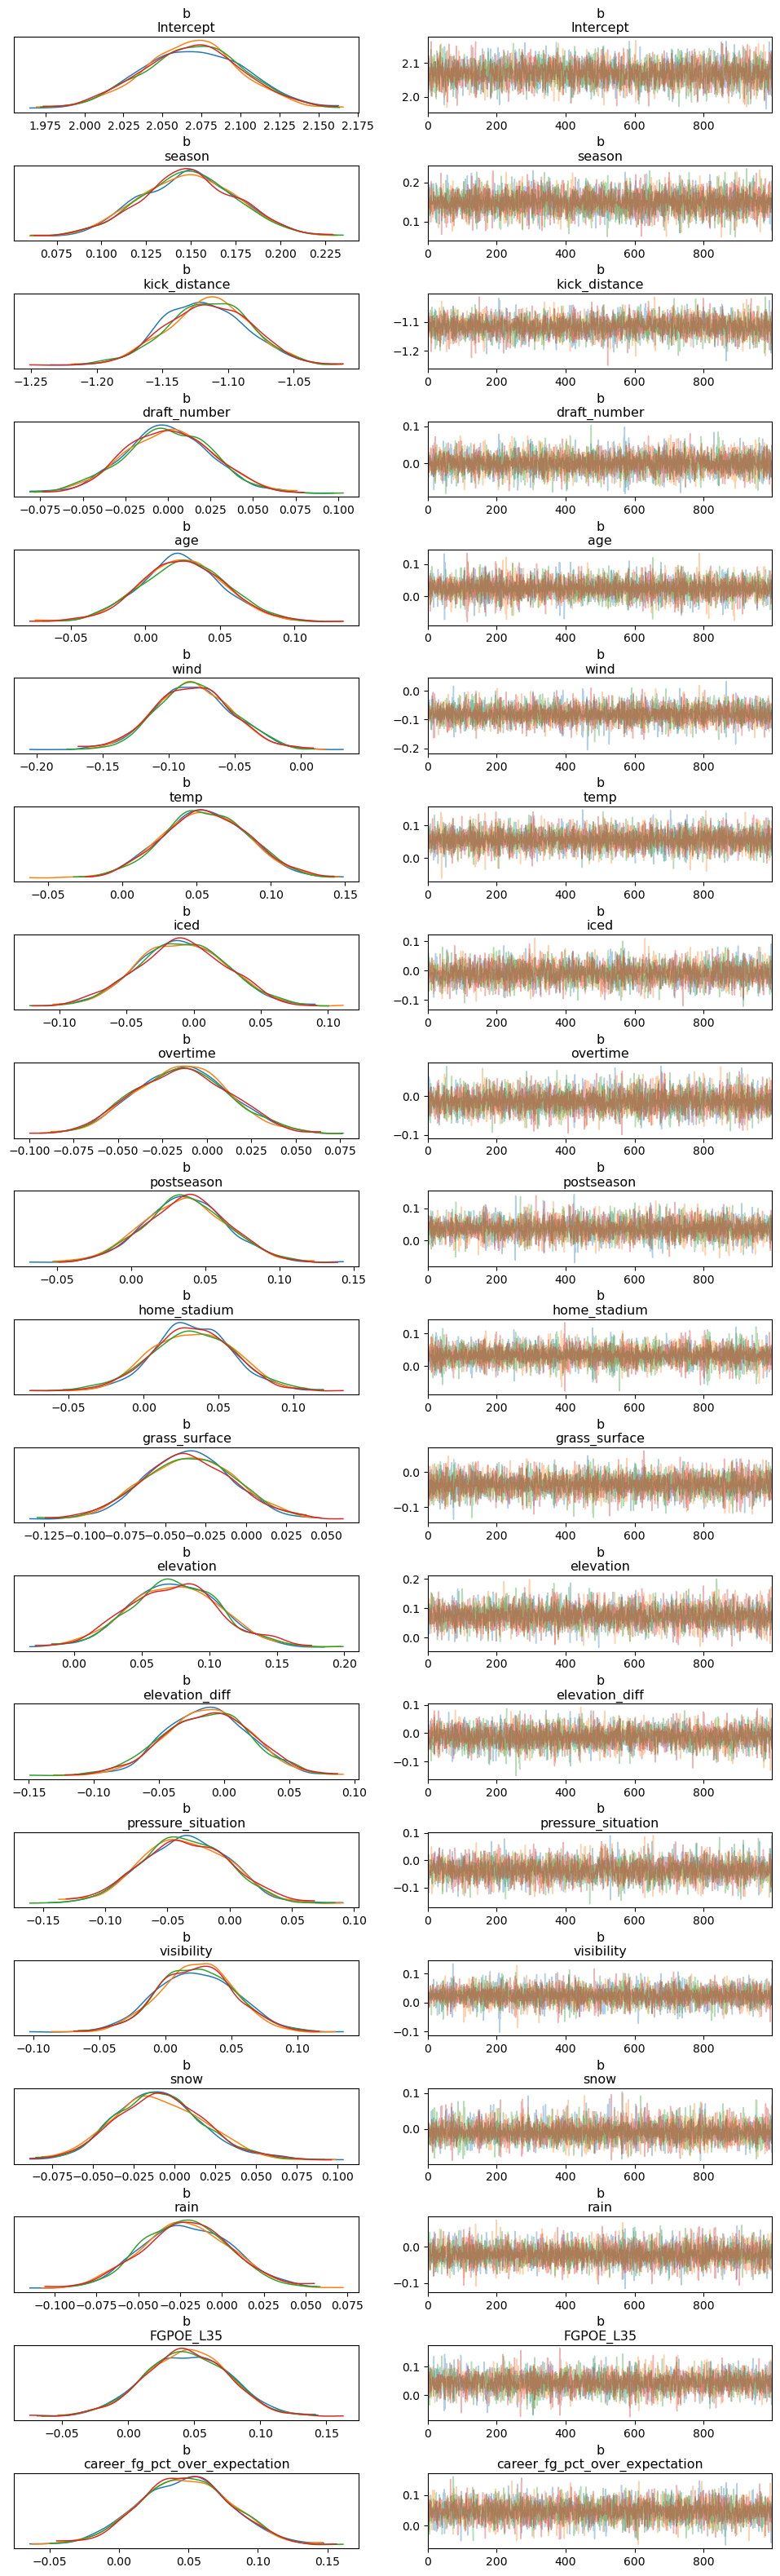

In [327]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

with logistic_model:
    idata = pm.sample()

# Plot trace with padding adjustments
az.plot_trace(idata, var_names="b", compact=False)
plt.subplots_adjust(hspace=0.7)  # Adjust the vertical space between plots
plt.show()

In [328]:
az.summary(idata, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Intercept],2.069,0.032,2.008,2.130,0.000,0.0,5340.0,3624.0,1.0
b[season],0.149,0.028,0.101,0.205,0.000,0.0,7777.0,3469.0,1.0
b[kick_distance],-1.116,0.032,-1.173,-1.055,0.000,0.0,5318.0,3553.0,1.0
b[draft_number],0.000,0.026,-0.048,0.049,0.000,0.0,7337.0,3351.0,1.0
b[age],0.025,0.028,-0.029,0.078,0.000,0.0,11507.0,2808.0,1.0
b[wind],-0.081,0.029,-0.133,-0.023,0.000,0.0,6850.0,3609.0,1.0
b[temp],0.056,0.029,-0.000,0.107,0.000,0.0,8398.0,3264.0,1.0
b[iced],-0.009,0.033,-0.072,0.053,0.000,0.0,4792.0,3434.0,1.0
b[overtime],-0.014,0.027,-0.062,0.037,0.000,0.0,7683.0,3245.0,1.0
b[postseason],0.037,0.028,-0.016,0.090,0.000,0.0,7007.0,3217.0,1.0


In [329]:
with logistic_model:
    pm.set_data({"X": X_test, "y": y_test})
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [y_obs]


Output()

In [ ]:
# Compute the point prediction by taking the mean and defining the category via a threshold.
p_test_pred = idata.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()

In [346]:
#    # Sample from the posterior
#     trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Predict probabilities on the test set
with logistic_model:
    pm.set_data({"X": X_test, "y": y_test})
    p_test = pm.sample_posterior_predictive(idata, var_names=['p'])
    p_test_mean = p_test['posterior_predictive']['p'].mean(axis=0).mean(axis=0)

# Calculate log loss on the test set
test_log_loss = log_loss(y_test, p_test_mean)``
print(f'Log Loss on the test set: {test_log_loss}')

# Predict probabilities on the entire dataset
with logistic_model:
    pm.set_data({"X": X_all_standardized, "y": y_all})
    p_test = pm.sample_posterior_predictive(idata, var_names=['p'])
    p_test_mean = p_test['posterior_predictive']['p'].mean(axis=0).mean(axis=0)

Sampling: []


Output()

Sampling: []


Output()